In [8]:
from pynth import *
import numpy as np
import matplotlib.pyplot as plt

定义一个振荡器，用于描述声音的波形。`take` 方法的参数 `p` 表示波形的相位，取值范围是 `[0, 1)`。这是一个脉冲波，默认占空比为 12.5%。

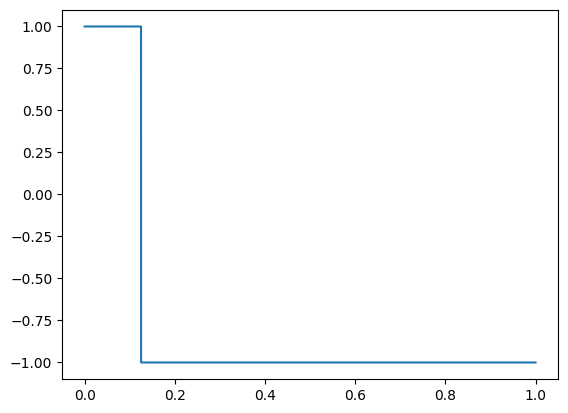

In [9]:
class Pulse(Oscillator):
    def __init__(self,  duty=0.125):
        self.duty = duty

    def take(self, p):
        return 1 if p < self.duty else -1


Pulse().plot()

用刚刚创建的振荡器作为波形，创建一个乐器。

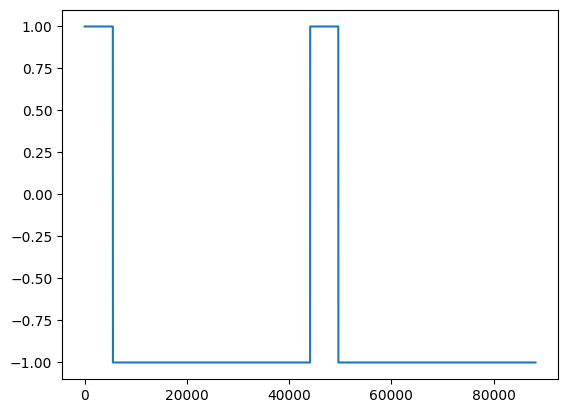

In [10]:
ins = Instrument(wav=Pulse())
ins.plot()
ins.audio()

再创建一个振荡器，用于描述声音的音量随时间的变化。这个类模拟了 Famitracker 中的 MML(Music Macro Language)。`take` 的参数 `d` 表示处理的数据的总时长，单位是秒。`t` 表示当前时间，取值范围是 `[0, d)`。

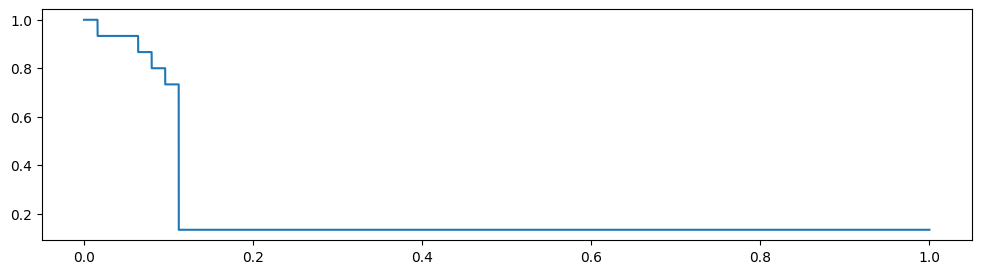

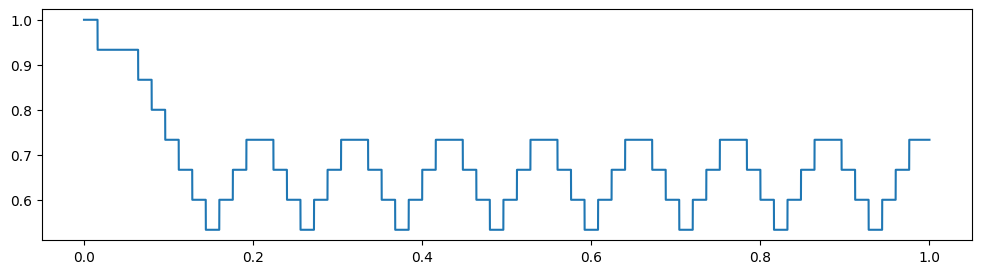

In [11]:
class Mml(Oscillator):
    def __init__(self, start, end=[], loop=[], proc=None):
        self.start = np.array(start)
        self.end = np.array(end)
        self.loop = np.array(loop if loop else [start[-1]])
        if proc:
            self.start = proc(self.start)
            self.end = proc(self.end)
            self.loop = proc(self.loop)

    def take(self, p, t, d):
        n = int((d - t) / 0.016)
        if n < self.end.size:
            return self.end[n]

        n = int(t / 0.016)
        if n < self.start.size:
            return self.start[n]

        n = (n - self.start.size) % self.loop.size
        return self.loop[n]


env_default = Mml([0xF, 0xE, 0xE, 0xE, 0xD, 0xC, 0xB, 0x2], proc=lambda x: x / 0xF)
env_tremolo = Mml([0xF, 0xE, 0xE, 0xE, 0xD, 0xC, 0xB], loop=[0xA, 0x9, 0x8, 0x9, 0xA, 0xB, 0xB], proc=lambda x: x / 0xF)

plt.figure(figsize=[12,3])
env_default.plot()

plt.figure(figsize=[12,3])
env_tremolo.plot()

`AudioCompiler` 可以把音符编译成声音。

In [12]:
AudioCompiler().audio(Instrument(wav=Pulse()), 120, [C(4)/4, D, E, F, G])

`Score` 表示乐谱，类似于编程中的 `Makefile`，可以组织多个声部。

In [13]:
s = Score(
    title="Dragon Quest II - Overture",
    composer="椙山浩一",
    tempo=276,
    parts=['pulse1', 'pulse2'],
)

s['pulse1'] = [let(wav=Pulse(0.50), amp=env_default)]
s['pulse2'] = [let(wav=Pulse(0.25), amp=env_default)]

s['pulse1'] += [A(4)/2, A/4, G, G, G, F,    G,    A, +A, A, G, A, +A, C(5),  D,  F,  D,  C, +A(4), A]
s['pulse2'] += [F(4)/2, F/4, C, C, C, A(3), C(4), F,  G, F, C, F,  G, A,    +A,  D, +A,  A,  F,    C]

s['pulse1'] += [G(4)/2, G/4, A/4*1.5, A/4, A, F,    A,    G.that(amp=env_tremolo)/1*2]
s['pulse2'] += [C(4)/2, F/4, F/4*1.5, F/4, F, A(3), F(4), C.that(amp=env_tremolo)/1*2]

s.audio()